## Data Mining and Machine Learning
### Logistic Regression: The  ROC curve
### Libraries:scikit-learn and h2o
#### Edgar Acuna

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import h2o
from h2o.estimators.glm  import H2OGeneralizedLinearEstimator

#h2o.connect()
#h2o.no_progress()
h2o.init(ip="localhost", port=54323)

Checking whether there is an H2O instance running at http://localhost:54323. connected.


H2O cluster uptime:,1 day 5 hours 56 mins
H2O cluster timezone:,America/La_Paz
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.2
H2O cluster version age:,2 months and 1 day
H2O cluster name:,H2O_from_python_edgar2017_ivtlb5
H2O cluster total nodes:,1
H2O cluster free memory:,1.624 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


### I Regresion Logistica para Diabetes usando scikit learn

In [3]:
url= "http://academic.uprm.edu/eacuna/diabetes.dat"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
data = pd.read_table(url, names=names,header=None)
#La variable de respuesta y debe ser binaria (0,1)
y=data['class']-1
X=data.iloc[:,0:8]
#Haciendo la regresion logistica ya calculando su precision
model = LogisticRegression()
model = model.fit(X, y)
print(model.coef_)

C:\Users\edgar2017\Anaconda2\envs\ipykernel_py3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[ 1.17052230e-01  2.83873955e-02 -1.68897224e-02  7.55274087e-04
  -6.42755924e-04  5.97603789e-02  6.77671880e-01  7.23947807e-03]]


In [4]:
# Tasa de precision
model.score(X, y)
predictions = model.predict(X)
print(classification_report(y, predictions))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       500
           1       0.74      0.55      0.63       268

   micro avg       0.77      0.77      0.77       768
   macro avg       0.76      0.72      0.73       768
weighted avg       0.77      0.77      0.77       768



### II. ROC curve using scikit-learn

In [5]:
#Hallando las probabilidades posteriores
probs = model.predict_proba(X)
preds = probs[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y, preds)
roc_auc = auc(false_positive_rate, true_positive_rate)

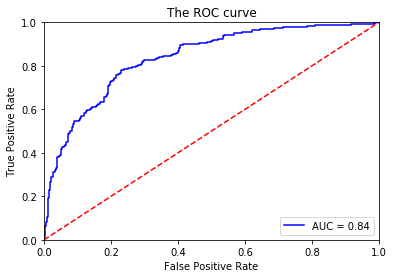

In [7]:
plt.title('The ROC curve')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1.0])
plt.ylim([0,1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The AUC value represents the area under the curve ROC (azul). Ia classifier has an  AUC between .9 and 1 then its predictions are very good, if the AUC lies between  .8 y .89 its prediction are good. A poor classifier is one with an  AUC less than de .60 de AUC.


### III Intersection of the sensitivity and  specifity curves to choose the threshold

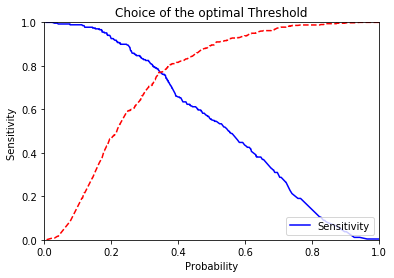

In [8]:
plt.title('Choice of the optimal Threshold')
plt.plot(thresholds, true_positive_rate, 'b',label='Sensitivity')
plt.legend(loc='lower right')
plt.plot(thresholds, 1-false_positive_rate,'r--')
plt.xlim([0,1.0])
plt.ylim([0,1.0])
plt.ylabel('Sensitivity ')
plt.xlabel('Probability')
plt.show()

El threshold que deberia ser usado en lugar de p=.5 para hacer la clasificacion sera aprox .35

### IV.  ROC curve using H20

In [9]:
diabetes = h2o.import_file("https://academic.uprm.edu/eacuna/diabetes.dat")
myx=['C1','C2','C3','C4','C5','C6','C7','C8']
diabetes['C9']=diabetes['C9'].asfactor()
myy='C9'
glm_model = H2OGeneralizedLinearEstimator(family= "binomial", lambda_ = 0, compute_p_values = True)
glm_model.train(myx, myy, training_frame= diabetes)
glm_model
glm_model._model_json['output']['coefficients_table']

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%
Coefficients: glm coefficients



names,coefficients,std_error,z_value,p_value,standardized_coefficients
Intercept,-8.4046964,0.7166361,-11.7279840,0.0,-0.8711017
C1,0.1231823,0.0320776,3.8401399,0.0001230,0.4150724
C2,0.0351637,0.0037087,9.4813920,0.0,1.1242760
C3,-0.0132955,0.0052336,-2.5404157,0.0110721,-0.2573460
C4,0.0006190,0.0068994,0.0897131,0.9285152,0.0098739
C5,-0.0011917,0.0009012,-1.3223092,0.1860652,-0.1373362
C6,0.0897010,0.0150876,5.9453328,0.0000000,0.7072168
C7,0.9451797,0.2991475,3.1595776,0.0015800,0.3131651
C8,0.0148690,0.0093348,1.5928583,0.1111920,0.1748629


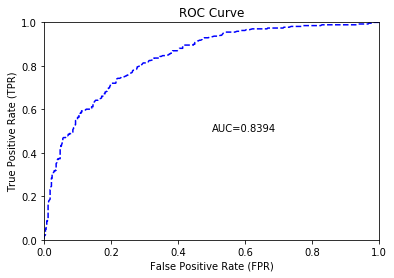

In [10]:
perf = glm_model.model_performance()  #train=True is the default, so it's not needed
perf.plot()

In [11]:
#Effect after using the threshokd
#Number of instances assigned to class 1 using p=.5
dp=data[preds>.5]
dp['class'].value_counts()

2    147
1     52
Name: class, dtype: int64

In [12]:
#Accuracy with p=.5
595*100/768.0

77.47395833333333

In [13]:
#Number of instances assigned to class 1 using p=.35
dp1=data[preds>.35]
dp1['class'].value_counts()

2    205
1    114
Name: class, dtype: int64

In [14]:
#New accuracy
591*100/768.0

76.953125